In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns



In [17]:
warnings.filterwarnings('ignore')

df = pd.read_csv('../dataset/Absenteeism_at_work.csv', sep=';')

# Целевая переменная
target = df['Absenteeism time in hours']
features = df.drop(columns=['Absenteeism time in hours', 'ID'])

# Проверка пропущенных значений
features.fillna(features.mode().iloc[0], inplace=True)


categorical_cols = ['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons',
                    'Disciplinary failure', 'Education', 'Social drinker', 'Social smoker']
label_encoders = {}



In [18]:
for col in categorical_cols:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col].astype(str))
    label_encoders[col] = le

# Масштабирование
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# PCA
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(scaled_features)

print(f"\nПризнаков до PCA: {scaled_features.shape[1]}")
print(f"Признаков после PCA: {pca_features.shape[1]}")


Признаков до PCA: 19
Признаков после PCA: 15


In [19]:


# Функции оценки и запуска кластеризации
def evaluate_clustering(X, labels, true_labels, method_name, dimensions, time_taken):
    silhouette = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else -1
    ari = adjusted_rand_score(true_labels, labels)
    return {
        'Method': method_name,
        'Dimensions': dimensions,
        'Silhouette Score': silhouette,
        'Adjusted Rand Index': ari,
        'Time (s)': time_taken,
        'Clusters': len(np.unique(labels))
    }

def apply_clustering_methods(X, true_labels, dimensions):
    results = []
    for k in [2, 3, 4, 5]:
        start_time = time.time()
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_labels = kmeans.fit_predict(X)
        time_taken = time.time() - start_time
        results.append(evaluate_clustering(X, kmeans_labels, true_labels, f'K-Means (k={k})', dimensions, time_taken))

    try:
        start_time = time.time()
        mean_shift = MeanShift()
        ms_labels = mean_shift.fit_predict(X)
        time_taken = time.time() - start_time
        results.append(evaluate_clustering(X, ms_labels, true_labels, 'Mean Shift', dimensions, time_taken))
    except Exception as e:
        print(f"Mean Shift error: {e}")

    for linkage in ['ward', 'complete', 'average']:
        start_time = time.time()
        agg = AgglomerativeClustering(n_clusters=2, linkage=linkage)
        agg_labels = agg.fit_predict(X)
        time_taken = time.time() - start_time
        results.append(evaluate_clustering(X, agg_labels, true_labels, f'Agglomerative ({linkage})', dimensions, time_taken))

    for eps in [0.5, 1.0, 1.5]:
        start_time = time.time()
        dbscan = DBSCAN(eps=eps, min_samples=5)
        dbscan_labels = dbscan.fit_predict(X)
        time_taken = time.time() - start_time
        results.append(evaluate_clustering(X, dbscan_labels, true_labels, f'DBSCAN (eps={eps})', dimensions, time_taken))

    return results


In [20]:

# Кластеризация
target_encoded = pd.qcut(target, q=4, labels=False)  # Преобразуем target в квази-категории

results_scaled = apply_clustering_methods(scaled_features, target_encoded, scaled_features.shape[1])
results_pca = apply_clustering_methods(pca_features, target_encoded, pca_features.shape[1])
all_results = results_scaled + results_pca
results_df = pd.DataFrame(all_results).sort_values(by='Adjusted Rand Index', ascending=False)

# Сохраняем и выводим
results_df.to_csv('absenteeism_clustering_results.csv', index=False)
print("\nЛучшие методы кластеризации:")
print(results_df.head(10).to_string(index=False))



Лучшие методы кластеризации:
          Method  Dimensions  Silhouette Score  Adjusted Rand Index  Time (s)  Clusters
DBSCAN (eps=1.5)          15         -0.064225             0.043099  0.016597        21
DBSCAN (eps=1.5)          19         -0.099321             0.039279  0.000000        20
   K-Means (k=5)          19          0.166586             0.038327  0.032983         5
   K-Means (k=4)          15          0.157313             0.036113  0.038541         4
   K-Means (k=4)          19          0.152645             0.034975  0.033102         4
   K-Means (k=3)          19          0.145227             0.031093  0.030994         3
   K-Means (k=3)          15          0.148669             0.028454  0.036638         3
   K-Means (k=5)          15          0.171016             0.027605  0.036581         5
DBSCAN (eps=1.0)          15         -0.225541             0.026592  0.014679        11
DBSCAN (eps=1.0)          19         -0.177884             0.021379  0.000000         7


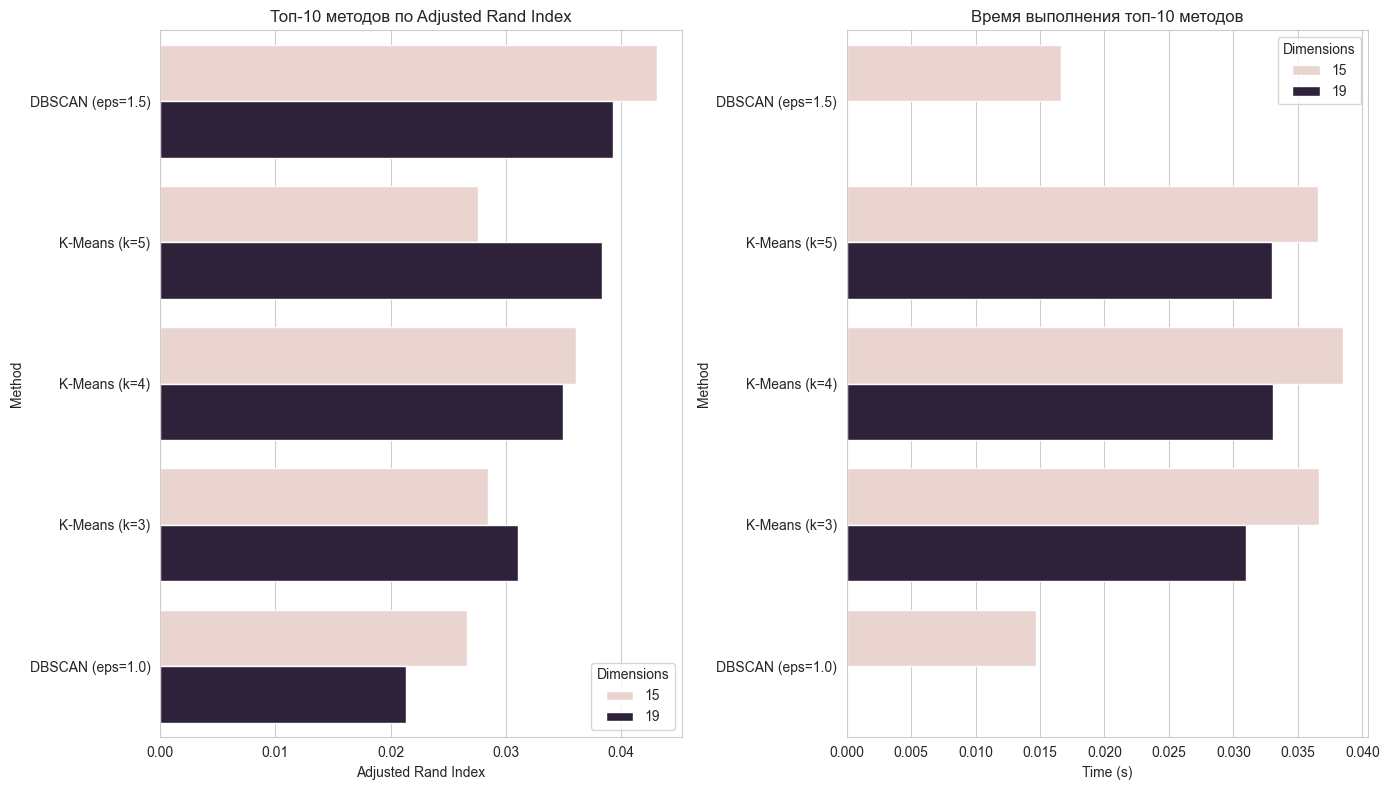

In [21]:

# Визуализация
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
sns.barplot(x='Adjusted Rand Index', y='Method', hue='Dimensions',
            data=results_df.head(10))
plt.title('Топ-10 методов по Adjusted Rand Index')

plt.subplot(1, 2, 2)
sns.barplot(x='Time (s)', y='Method', hue='Dimensions',
            data=results_df.head(10))
plt.title('Время выполнения топ-10 методов')

plt.tight_layout()
plt.savefig('absenteeism_clustering_comparison.png', dpi=300)
plt.show()

In [22]:


# Анализ лучшего
best_method = results_df.iloc[0]
print(f"\n🏆 Лучший метод кластеризации: {best_method['Method']}")
print(f"ARI: {best_method['Adjusted Rand Index']:.3f}")
print(f"Silhouette: {best_method['Silhouette Score']:.3f}")
print(f"Время: {best_method['Time (s)']:.3f} сек")
print(f"Кластеры: {best_method['Clusters']}")


🏆 Лучший метод кластеризации: DBSCAN (eps=1.5)
ARI: 0.043
Silhouette: -0.064
Время: 0.017 сек
Кластеры: 21
